This notebook contains functionality to perform the following:

Exploring arabidopsis dataset that arrived in `.bed` format. Implementing inaccessible downsampling algorithm. Formatting into proper output, visualizing and saving full dataset, downsampled inaccessible dataset, and accessible dataset.

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/Shareddrives/NRC_Amii_Agronomics_Project/nrc-ml-plant-genomics/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/NRC_Amii_Agronomics_Project/nrc-ml-plant-genomics


In [ ]:
import argparse
import keras
import warnings, logging
import numpy as np
import pandas as pd
import datetime, time, os
import json
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from keras.models import Sequential, load_model, model_from_json
from keras.layers import Input, Dense, Conv1D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam  # https://stackoverflow.com/questions/62707558/importerror-cannot-import-name-adam-from-keras-optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping  # https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from collections import Counter

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, roc_auc_score
from scipy.stats import spearmanr  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

warnings.filterwarnings('ignore')
logging.disable(1000)

# tf.random.set_seed(1202)  # https://www.tensorflow.org/api_docs/python/tf/random/set_seed
# from numpy.random import seed
# seed(1202)

random.seed(1234)

nts = ["A", "T", "C", "G"]  # list of single nucleotides
mapping = {"A": [1, 0, 0, 0], "T": [0, 0, 0, 1], "C": [0, 1, 0, 0], "G": [0, 0, 1, 0], "X":[0, 0, 0, 0]}  # cross referenced with kipoi data loader

def Spearman(y_true, y_pred):
     return (tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32), 
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )

In [ ]:
df = pd.read_csv("data/raw/athal_starr.acr.regions.bed", sep="\t", header=None)

In [ ]:
df.columns = ["ref",
              "start",
              "stop",
              "sequence",
              "control_raw_value", 
              "starr_raw_value", 
              "control_normalized", 
              "starr_normalized",
              "ACR_flag",
              "region"]

## Explore annotated dataset

In [ ]:
df.sequence.str.len()

0          153
1          153
2          153
3          153
4          153
          ... 
7039215    153
7039216    153
7039217    153
7039218    153
7039219    153
Name: sequence, Length: 7039220, dtype: int64

In [ ]:
df = df[df.ref.isin(["Chr"+str(i) for i in range(1,6)])]  # keep rows with "Chr" in the chromosome column

# if downsize:
#   df = df.iloc[::downsize, :]  # select every nth row

odds = [s for s in list(set("".join(df.sequence))) if s not in ["A", "T", "C", "G"]]

mask = df.sequence.str.contains("|".join(odds))  # true if contains weird characters, false if contains only ATCG
df = df[np.logical_not(mask)]  # keep only rows without weird characters

df = df[(df.control_raw_value >= 30) & (df.starr_raw_value >= 5)]

df["target"] = np.log2(df.control_normalized/df.starr_normalized)

df["set"] = "train"
picked = ["Chr2","Chr4"]
random.Random(1202).shuffle(picked)
# set val and test by chromosome we want
df.loc[df.ref == picked[0], "set"] = "val"
df.loc[df.ref == picked[1], "set"] = "test"

In [ ]:
df.shape

(7039220, 10)

In [ ]:
df.groupby("set").count().iloc[:,0]

set
test      765855
train    3331306
val       791847
Name: ref, dtype: int64

In [ ]:
df.groupby("ref").count().iloc[:,0]

ref
Chr1    1248771
Chr2     791847
Chr3     968480
Chr4     765855
Chr5    1114055
Name: start, dtype: int64

In [ ]:
df.groupby("ACR_flag").count().iloc[:,0]  # 4.85% accessible

ACR_flag
0    4677024
1     211984
Name: ref, dtype: int64

In [ ]:
df.groupby("region").count().iloc[:,0]

region
distal         165153
genic         3212691
intergenic     706713
proximal       804451
Name: ref, dtype: int64

In [ ]:
df[df.ACR_flag == 0].groupby("ref").count()

,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target
ref,,,,,,,,,,
Chr1,1192436,1192436,1192436,1192436,1192436,1192436,1192436,1192436,1192436,1192436
Chr2,757241,757241,757241,757241,757241,757241,757241,757241,757241,757241
Chr3,928172,928172,928172,928172,928172,928172,928172,928172,928172,928172
Chr4,729822,729822,729822,729822,729822,729822,729822,729822,729822,729822
Chr5,1069353,1069353,1069353,1069353,1069353,1069353,1069353,1069353,1069353,1069353


In [ ]:
df[df.ACR_flag == 1].groupby("ref").count()

,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target
ref,,,,,,,,,,
Chr1,56335,56335,56335,56335,56335,56335,56335,56335,56335,56335
Chr2,34606,34606,34606,34606,34606,34606,34606,34606,34606,34606
Chr3,40308,40308,40308,40308,40308,40308,40308,40308,40308,40308
Chr4,36033,36033,36033,36033,36033,36033,36033,36033,36033,36033
Chr5,44702,44702,44702,44702,44702,44702,44702,44702,44702,44702


In [ ]:
n = 1  # such that there is no overlap

fig = plt.figure(figsize=[20,5])

fig.patch.set_facecolor('white')

plt.plot(df.ACR_flag[::n])  # selected every nth row
plt.xlabel("Sequence Position")
plt.ylabel("Bit")
plt.title("Accessibility Bit Over the Entire Sequence")
plt.show()

In [ ]:
# figure out distributions of accessible stretches

bit_list = df.ACR_flag.tolist()
stretch_list = []
ctr = 0
for i in range(1, df.shape[0]):
  if bit_list[i] == 1:
    ctr += 1
  if bit_list[i-1] == 1 and bit_list[i] == 0:
    stretch_list.append(ctr)
    ctr = 0

In [ ]:
sum(stretch_list)

211984

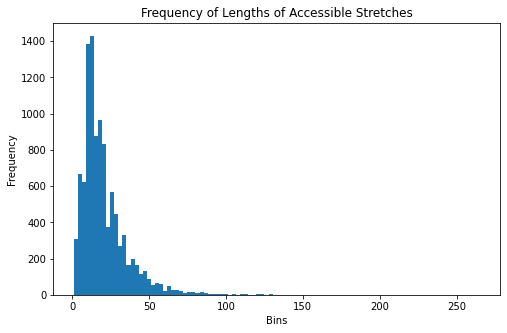

In [ ]:
fig = plt.figure(figsize=[8,5])

fig.patch.set_facecolor('white')

plt.hist(stretch_list, bins=100)  # selected every nth row
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Frequency of Lengths of Accessible Stretches")
plt.show()

## Save annotated dataset

In [ ]:
# pre-processing

df = df[df.ref.isin(["Chr"+str(i) for i in range(1,6)])]  # keep rows with "Chr" in the chromosome column

# if downsize:
#   df = df.iloc[::downsize, :]  # select every nth row

odds = [s for s in list(set("".join(df.sequence))) if s not in ["A", "T", "C", "G"]]

mask = df.sequence.str.contains("|".join(odds))  # true if contains weird characters, false if contains only ATCG
df = df[np.logical_not(mask)]  # keep only rows without weird characters

df = df[(df.control_raw_value >= 30) & (df.starr_raw_value >= 5)]

df["target"] = np.log2(df.control_normalized/df.starr_normalized)

df["set"] = "train"
picked = ["Chr2","Chr4"]
random.Random(1202).shuffle(picked)
# set val and test by chromosome we want
df.loc[df.ref == picked[0], "set"] = "val"
df.loc[df.ref == picked[1], "set"] = "test"

In [ ]:
df
# create new attributes to split on - change in ACR_flag!

,ref,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target,set
202,Chr1,3434,3587,ATCTTAATAGTTAATACTACTCGGTTTACTACATGAAATTTCATAC...,31,23,0.71,0.73,0,proximal,-0.040077,train
203,Chr1,3451,3604,TACTCGGTTTACTACATGAAATTTCATACCATCAATTGTTTTAATA...,35,28,0.80,0.89,0,proximal,-0.153805,train
204,Chr1,3468,3621,GAAATTTCATACCATCAATTGTTTTAATAATCTTTAAAATTGTTAG...,35,28,0.80,0.89,0,proximal,-0.153805,train
205,Chr1,3485,3638,ATTGTTTTAATAATCTTTAAAATTGTTAGGACCGGTAAAACCATAC...,35,30,0.80,0.96,0,proximal,-0.263034,train
206,Chr1,3502,3655,TAAAATTGTTAGGACCGGTAAAACCATACCAATTAAACCGGAGATC...,32,29,0.73,0.92,0,proximal,-0.333737,train
...,...,...,...,...,...,...,...,...,...,...,...,...
7008561,Chr5,26975260,26975413,CTCACGGCCGGCTCTGGTCTAAACACTTACGTCACGTTTGAACAAA...,41,21,0.93,0.67,0,intergenic,0.473070,train
7008562,Chr5,26975277,26975430,TCTAAACACTTACGTCACGTTTGAACAAACACATAGTTGAGACTCT...,39,20,0.89,0.64,0,intergenic,0.475733,train
7008563,Chr5,26975294,26975447,CGTTTGAACAAACACATAGTTGAGACTCTTATGCAAACTCACATGT...,35,18,0.80,0.57,0,intergenic,0.489038,train
7008564,Chr5,26975311,26975464,AGTTGAGACTCTTATGCAAACTCACATGTTAGAAACACTTATACAA...,33,16,0.75,0.51,0,intergenic,0.556393,train


In [ ]:
df = df[["sequence", "target", "ACR_flag", "set"]]
# df["sequence"] += "XXXXXXXX"   # pads

In [ ]:
df[df.ACR_flag == 0].to_csv("data/processed/arabidopsis_inaccessible.csv")

In [ ]:
df[df.ACR_flag == 1].to_csv("data/processed/arabidopsis_accessible.csv")

# Create Downsampled Inaccessible Dataset

In [ ]:
# pre-processing

df = df[df.ref.isin(["Chr"+str(i) for i in range(1,6)])]  # keep rows with "Chr" in the chromosome column

# if downsize:
#   df = df.iloc[::downsize, :]  # select every nth row

odds = [s for s in list(set("".join(df.sequence))) if s not in ["A", "T", "C", "G"]]

mask = df.sequence.str.contains("|".join(odds))  # true if contains weird characters, false if contains only ATCG
df = df[np.logical_not(mask)]  # keep only rows without weird characters

df = df[(df.control_raw_value >= 30) & (df.starr_raw_value >= 5)]

df["target"] = np.log2(df.control_normalized/df.starr_normalized)

df["set"] = "train"
picked = ["Chr2","Chr4"]
random.Random(1202).shuffle(picked)
# set val and test by chromosome we want
df.loc[df.ref == picked[0], "set"] = "val"
df.loc[df.ref == picked[1], "set"] = "test"

## Create acc_chunks and inacc_chunks

### Split dataset into chunks

In [ ]:
# create new column that indicates where to split the data - both by removed due to insufficient reads or due to 0->1 or 1->0
split_reads = [0] + [1 if df.start.iloc[i] - df.start.iloc[i-1] > 17 else 0 for i in range(1, df.shape[0])]
df["split_reads"] = split_reads

In [ ]:
split_accessible = [0] + [1 if df.ACR_flag.iloc[i] != df.ACR_flag.iloc[i-1] else 0 for i in range(1, df.shape[0])]
df["split_accessible"] = split_accessible

In [ ]:
df["split"] = np.logical_or(split_reads, split_accessible).astype(int)  # creates one column where everything before (and including?) the 1 is added to chunk list 

In [ ]:
# create function that splits dataset

def split_into_chunks(df):  
  # takes in df with attribute "split"
  # split contains a 1 in rows are directly after the boundary where the dataframe needs to be split

  last_1_idx = 0
  chunks = []
  split_list = df.split.tolist()
  print(len(split_list))

  # wherever there is a 1 in df.split
  for i in range(len(split_list)):  # does not capture the very last row unfortunately. Sorry row 🫡
    if split_list[i] == 1:
      current_1_idx = i
      chunks.append(df.iloc[last_1_idx:current_1_idx])
      last_1_idx = current_1_idx

  return chunks

In [ ]:
## testing

# df_bitty = df[:100]
# split = [0]*100
# split[7] = split[23] = split[60] = 1
# df_bitty["split"] = split
# lst = split_into_chunks(df_bitty)

In [ ]:
chunks = split_into_chunks(df)

4889008


In [ ]:
len(chunks)

58592

In [ ]:
# make sure there are no chunks with multiple accessibility bits -- all 1 or 0 😎
for chunk in chunks:
  if np.mean(chunk.ACR_flag) not in [0.0, 1.0]:
    print("oopsie")

In [ ]:
chunk_lens = [chunk.shape[0] for chunk in chunks]
np.mean(chunk_lens)

83.43304546695795

In [ ]:
# split chunks based on accessible vs inaccessible
acc_chunks = []
inacc_chunks = []
for chunk in chunks:
  if chunk.ACR_flag.iloc[0] == 1:
    acc_chunks.append(chunk)
  elif chunk.ACR_flag.iloc[0] == 0:
    inacc_chunks.append(chunk)
  else:
    print("oopsie")

In [ ]:
acc_chunks_lens = [chunk.shape[0] for chunk in acc_chunks]
len(acc_chunks), min(acc_chunks_lens), max(acc_chunks_lens), np.mean(acc_chunks_lens), np.median(acc_chunks_lens)

(11759, 1, 179, 18.027383280891232, 15.0)

In [ ]:
inacc_chunks_lens = [chunk.shape[0] for chunk in inacc_chunks]
len(inacc_chunks), min(inacc_chunks_lens), max(inacc_chunks_lens), np.mean(inacc_chunks_lens), np.median(inacc_chunks_lens)

(46833, 1, 7721, 99.85533704866226, 38.0)

In [ ]:
# get rid of highest outliers (>1000 in length)
nonout_inacc_chunks = [chunk for chunk in inacc_chunks if chunk.shape[0] < 1000]

In [ ]:
len(nonout_inacc_chunks)

46680

In [ ]:
# see if train/test/val split is decently even between accessible and inaccessible
df_inacc = pd.concat(inacc_chunks)
df_inacc.groupby("set").count()

,ref,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target,split_reads,split_accessible,split
set,,,,,,,,,,,,,,
test,729822,729822,729822,729822,729822,729822,729822,729822,729822,729822,729822,729822,729822,729822
train,3189462,3189462,3189462,3189462,3189462,3189462,3189462,3189462,3189462,3189462,3189462,3189462,3189462,3189462
val,757241,757241,757241,757241,757241,757241,757241,757241,757241,757241,757241,757241,757241,757241


In [ ]:
# see if train/test/val split is decently even between accessible and inaccessible
df_acc = pd.concat(acc_chunks)
df_acc.groupby("set").count()

,ref,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target,split_reads,split_accessible,split
set,,,,,,,,,,,,,,
test,36033,36033,36033,36033,36033,36033,36033,36033,36033,36033,36033,36033,36033,36033
train,141345,141345,141345,141345,141345,141345,141345,141345,141345,141345,141345,141345,141345,141345
val,34606,34606,34606,34606,34606,34606,34606,34606,34606,34606,34606,34606,34606,34606


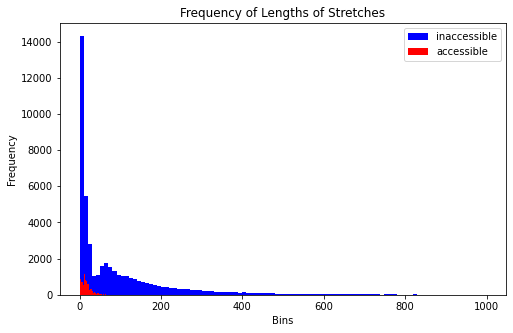

In [ ]:
fig = plt.figure(figsize=[8,5])

fig.patch.set_facecolor('white')

plt.hist([chunk.shape[0] for chunk in nonout_inacc_chunks], bins=100, color="b", label="inaccessible")  # selected every nth row
plt.hist([chunk.shape[0] for chunk in acc_chunks], bins=100, color="r", label="accessible")  # selected every nth row
plt.legend()

plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Frequency of Lengths of Stretches")
plt.show()

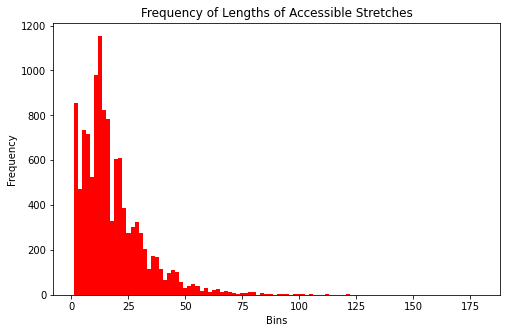

In [ ]:
fig = plt.figure(figsize=[8,5])

fig.patch.set_facecolor('white')

# plt.hist([chunk.shape[0] for chunk in inacc_chunks], bins=100, color="b")  # selected every nth row
plt.hist([chunk.shape[0] for chunk in acc_chunks], bins=100, color="r")  # selected every nth row

plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Frequency of Lengths of Accessible Stretches")
plt.show()

### Trim chunks

Index 9 is the first index that we see no overlap with index 0 - therefore we have to get rid of 8 total rows to eliminate overlap

In [ ]:
def trim(chunks_list):
  trimmed_list = []
  for chunk in chunks_list:
    if chunk.shape[0] > 8:  # that is, there will be something left after trimming
      trimmed_list.append(chunk.iloc[4:-4,:])

  return trimmed_list

In [ ]:
# get rid of 4 rows on each side of 
inacc_chunks_trimmed = trim(inacc_chunks)
acc_chunks_trimmed = trim(acc_chunks)

In [ ]:
acc_chunks_trimmed_lens = [chunk.shape[0] for chunk in acc_chunks_trimmed]
len(acc_chunks_trimmed), min(acc_chunks_trimmed_lens), max(acc_chunks_trimmed_lens), np.mean(acc_chunks_trimmed_lens), np.median(acc_chunks_trimmed_lens)

(8979, 1, 171, 14.233990422096001, 10.0)

In [ ]:
sum(acc_chunks_trimmed_lens)

127807

In [ ]:
inacc_chunks_trimmed_lens = [chunk.shape[0] for chunk in inacc_chunks_trimmed]
len(inacc_chunks_trimmed), min(inacc_chunks_trimmed_lens), max(inacc_chunks_trimmed_lens), np.mean(inacc_chunks_trimmed_lens), np.median(inacc_chunks_trimmed_lens)

(33688, 1, 7713, 129.6550997387794, 76.0)

In [ ]:
sum(inacc_chunks_trimmed_lens)

4367821

In [ ]:
# see if train/test/val split is decently even between accessible and inaccessible
df_inacc = pd.concat(inacc_chunks_trimmed)
df_inacc.groupby("set").count()

,ref,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target,split_reads,split_accessible,split
set,,,,,,,,,,,,,,
test,681150,681150,681150,681150,681150,681150,681150,681150,681150,681150,681150,681150,681150,681150
train,2980134,2980134,2980134,2980134,2980134,2980134,2980134,2980134,2980134,2980134,2980134,2980134,2980134,2980134
val,706537,706537,706537,706537,706537,706537,706537,706537,706537,706537,706537,706537,706537,706537


In [ ]:
# see if train/test/val split is decently even between accessible and inaccessible
df_acc = pd.concat(acc_chunks_trimmed)
df_acc.groupby("set").count()

,ref,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target,split_reads,split_accessible,split
set,,,,,,,,,,,,,,
test,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316
train,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669
val,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822


In [ ]:
# get rid of highest outliers (>1000 in length)
nonout_inacc_chunks_trimmed = [chunk for chunk in inacc_chunks_trimmed if chunk.shape[0] < 1000]

In [ ]:
len(nonout_inacc_chunks_trimmed)

33540

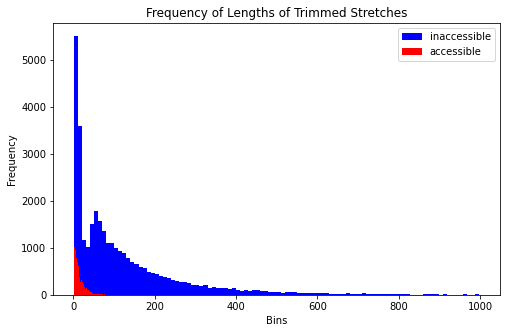

In [ ]:
fig = plt.figure(figsize=[8,5])

fig.patch.set_facecolor('white')

plt.hist([chunk.shape[0] for chunk in nonout_inacc_chunks_trimmed], bins=100, color="b", label="inaccessible")  # selected every nth row
plt.hist([chunk.shape[0] for chunk in acc_chunks_trimmed], bins=100, color="r", label="accessible")  # selected every nth row
plt.legend()

plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Frequency of Lengths of Trimmed Stretches")
plt.show()

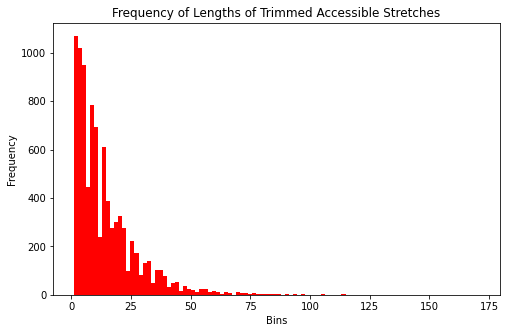

In [ ]:
fig = plt.figure(figsize=[8,5])

fig.patch.set_facecolor('white')

# plt.hist([chunk.shape[0] for chunk in inacc_chunks], bins=100, color="b")  # selected every nth row
plt.hist([chunk.shape[0] for chunk in acc_chunks_trimmed], bins=100, color="r")  # selected every nth row

plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Frequency of Lengths of Trimmed Accessible Stretches")
plt.show()

## Downsample inacc_chunks

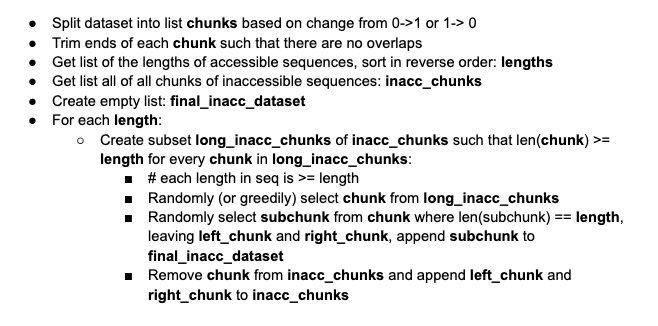

In [ ]:
# inacc_chunks_trimmed
lengths = sorted(acc_chunks_trimmed_lens, reverse=True)
final_inacc_dataset = []

In [ ]:
ids = [chunk.index[0] for chunk in inacc_chunks_trimmed]  
len(ids) == len(list(set(ids)))  # true if all ids are unique

True

In [ ]:
def split_thricely(chunk, length):  
  chunk_size = chunk.shape[0]

  if chunk_size == length:
    return [chunk]
  else:
    chunks_list = []

    # calculate chunk length - length
    start_idx = random.randint(0, chunk_size-length)
    # print("Start index:", start_idx)
    # create actual subchunk
    chunks_list.append(chunk.iloc[start_idx:start_idx+length])

    # add left subchunk and right subchunk if they exist
    left = chunk.iloc[0:start_idx]
    right = chunk.iloc[start_idx+length:chunk_size]

    if left.shape[0] > 0:  # if there's a left subchunk of length >= 1 to add
      chunks_list.append(left)
    if right.shape[0] > 0:  # if there's a right subchunk of length >= 1 to add
      chunks_list.append(right)

    # print([chunk.shape[0] for chunk in chunks_list])
    return chunks_list

In [ ]:
for length in lengths:
  # print("length:", length)

  long_inacc_chunks = [chunk for chunk in inacc_chunks_trimmed if chunk.shape[0] >= length]  # create subset of inacc_chunks_trimmed where len(all chunks) > length
  # randomly select chunk from list
  chunk = random.choice(long_inacc_chunks)
  # print("chunksize:", chunk.shape[0])  

  # randomly select subchunk from chunk
  subchunks = split_thricely(chunk, length)
  # print(len(subchunks))

  # add subchunk to 
  final_inacc_dataset.append(subchunks[0])
  # print(subchunks[0].shape)

  # remove chunk from inacc_chunks_trimmed based on first index position
  subchunk_indentifier = subchunks[0].index[0]
  # print("Subchunk identifier:", subchunk_indentifier)
  inacc_chunks_trimmed = [chunk for chunk in inacc_chunks_trimmed if chunk.index[0] != subchunk_indentifier]

  # add others back in if they exist
  if len(subchunks) > 1:
    inacc_chunks_trimmed += subchunks[1:]

In [ ]:
len(final_inacc_dataset)

8979

In [ ]:
len(acc_chunks_trimmed)

8979

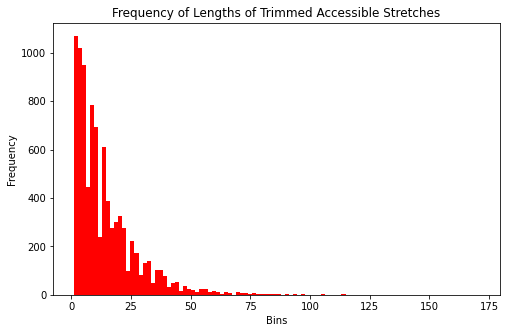

In [ ]:
fig = plt.figure(figsize=[8,5])

fig.patch.set_facecolor('white')

# plt.hist([chunk.shape[0] for chunk in inacc_chunks], bins=100, color="b")  # selected every nth row
plt.hist([chunk.shape[0] for chunk in acc_chunks_trimmed], bins=100, color="r")  # selected every nth row

plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Frequency of Lengths of Trimmed Accessible Stretches")
plt.show()

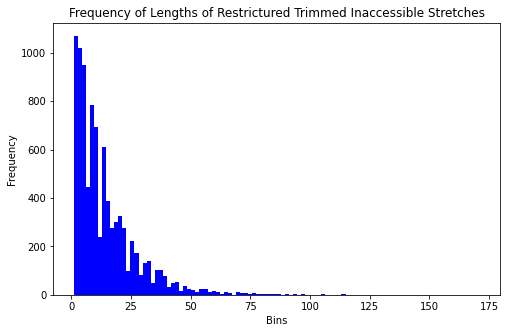

In [ ]:
fig = plt.figure(figsize=[8,5])

fig.patch.set_facecolor('white')

# plt.hist([chunk.shape[0] for chunk in inacc_chunks], bins=100, color="b")  # selected every nth row
plt.hist([chunk.shape[0] for chunk in final_inacc_dataset], bins=100, color="b")  # selected every nth row

plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Frequency of Lengths of Restrictured Trimmed Inaccessible Stretches")
plt.show()

In [ ]:
acc_chunks_trimmed_lens = [chunk.shape[0] for chunk in acc_chunks_trimmed]
len(acc_chunks_trimmed), min(acc_chunks_trimmed_lens), max(acc_chunks_trimmed_lens), np.mean(acc_chunks_trimmed_lens), np.median(acc_chunks_trimmed_lens)

(8979, 1, 171, 14.233990422096001, 10.0)

In [ ]:
sum(acc_chunks_trimmed_lens)

127807

In [ ]:
inacc_chunks_trimmed_lens = [chunk.shape[0] for chunk in final_inacc_dataset]
len(final_inacc_dataset), min(inacc_chunks_trimmed_lens), max(inacc_chunks_trimmed_lens), np.mean(inacc_chunks_trimmed_lens), np.median(inacc_chunks_trimmed_lens)

(8979, 1, 171, 14.233990422096001, 10.0)

In [ ]:
sum(inacc_chunks_trimmed_lens)

127807

In [ ]:
# see if train/test/val split is decently even between accessible and inaccessible
df_inacc = pd.concat(final_inacc_dataset)
df_inacc.groupby("set").count()

,ref,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target,split_reads,split_accessible,split
set,,,,,,,,,,,,,,
test,18421,18421,18421,18421,18421,18421,18421,18421,18421,18421,18421,18421,18421,18421
train,87723,87723,87723,87723,87723,87723,87723,87723,87723,87723,87723,87723,87723,87723
val,21663,21663,21663,21663,21663,21663,21663,21663,21663,21663,21663,21663,21663,21663


In [ ]:
# see if train/test/val split is decently even between accessible and inaccessible
df_acc = pd.concat(acc_chunks_trimmed)
df_acc.groupby("set").count()

,ref,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target,split_reads,split_accessible,split
set,,,,,,,,,,,,,,
test,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316,22316
train,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669,84669
val,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822,20822


## Create and save new datasets

### Combine chunks into separate datasets

In [ ]:
df_inacc

,ref,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target,set,split_reads,split_accessible,split
6419114,Chr5,16954661,16954814,AGTGTGAGATATAAGAAGTAACAAAACCAAGAAATCGTAAAACGAA...,75,30,1.71,0.96,0,genic,0.832890,train,0,0,0
6419115,Chr5,16954678,16954831,GTAACAAAACCAAGAAATCGTAAAACGAAATATGAAACTAATGCAA...,78,30,1.78,0.96,0,genic,0.890771,train,0,0,0
6419116,Chr5,16954695,16954848,TCGTAAAACGAAATATGAAACTAATGCAACTTACTTTGGCGCTCCA...,79,30,1.80,0.96,0,genic,0.906891,train,0,0,0
6419117,Chr5,16954712,16954865,AAACTAATGCAACTTACTTTGGCGCTCCACAGTTACAGGGGATTTT...,81,29,1.85,0.92,0,genic,1.007820,train,0,0,0
6419118,Chr5,16954729,16954882,TTTGGCGCTCCACAGTTACAGGGGATTTTGTCGTCCTCCAATGGGA...,78,27,1.78,0.86,0,genic,1.049469,train,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5293557,Chr4,16405102,16405255,TGCTTCACATTAAAAAAGCATACAGCAATGAGCATGAAAGTCACAC...,100,56,2.28,1.79,0,genic,0.349074,test,0,0,0
6904079,Chr5,25199066,25199219,GTTCAAAGTGTTAACCGCTGCTTTATACGCTAAATATAAGAAAAGA...,167,187,3.80,5.96,0,genic,-0.649313,train,0,0,0
484043,Chr1,8228731,8228884,ACAGCTGTTTCCGGCAACGGTTTTATCGCACAAGGCATAACATTCG...,92,97,2.10,3.09,0,genic,-0.557218,train,0,0,0
3524488,Chr3,9790623,9790776,TGAGATGAATCCAAAAAGATGTGCAGCTTGCAAGTATCTGAGAAGA...,37,10,0.84,0.32,0,genic,1.392317,train,0,0,0


In [ ]:
df_acc

,ref,start,stop,sequence,control_raw_value,starr_raw_value,control_normalized,starr_normalized,ACR_flag,region,target,set,split_reads,split_accessible,split
1220,Chr1,20740,20893,TTTGGTCGGTATGTGTATAATATTATACAATTATAATATATTTCTA...,50,38,1.14,1.21,1,intergenic,-0.085973,train,0,0,0
1221,Chr1,20757,20910,TAATATTATACAATTATAATATATTTCTAGGTTTAGACATTTTTTT...,54,43,1.23,1.37,1,intergenic,-0.155518,train,0,0,0
1222,Chr1,20774,20927,AATATATTTCTAGGTTTAGACATTTTTTTATTTTATTTTTCATGAA...,62,48,1.41,1.53,1,intergenic,-0.117836,train,0,0,0
1223,Chr1,20791,20944,AGACATTTTTTTATTTTATTTTTCATGAAGTAAAGAACACAAACAA...,67,51,1.53,1.63,1,intergenic,-0.091340,train,0,0,0
1224,Chr1,20808,20961,ATTTTTCATGAAGTAAAGAACACAAACAAAAACCCATAAAATAATG...,65,53,1.48,1.69,1,intergenic,-0.191426,train,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7006395,Chr5,26938438,26938591,TTTTTTTGTGCTGAAGAGGTGGAGCGTTGTGTGCATGAGTTTATAT...,93,91,2.12,2.90,1,proximal,-0.451989,train,0,0,0
7006396,Chr5,26938455,26938608,GGTGGAGCGTTGTGTGCATGAGTTTATATATGAGATATTAAAAGTT...,89,85,2.03,2.71,1,proximal,-0.416813,train,0,0,0
7006397,Chr5,26938472,26938625,ATGAGTTTATATATGAGATATTAAAAGTTACTTAAACGCTGCCGTT...,91,85,2.07,2.71,1,proximal,-0.388662,train,0,0,0
7006398,Chr5,26938489,26938642,ATATTAAAAGTTACTTAAACGCTGCCGTTTCTCACAGTGAGAATTA...,87,81,1.98,2.58,1,proximal,-0.381871,train,0,0,0


### Save datasets

In [ ]:
ls

 data/         'Larry Proposal.gdoc'   notebooks/   requirements.txt
 driver.ipynb   legacy/                output.csv   src/
 experiments/   models/                README.md


In [ ]:
df_acc.to_csv("data/processed/athal_accessible.csv", index=False)
df_inacc.to_csv("data/processed/athal_inaccessible.csv", index=False)